In [38]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

# import phenom

import lal
import lalsimulation as lalsim

# import lalutils

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [10]:
LALINFERENCE_INSTALL = True
from lalsimulation import SimInspiralTransformPrecessingNewInitialConditions
from lal import MSUN_SI

In [104]:
def component_spins(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2, mass_1,
                    mass_2, f_ref, phase):
    """Return the component spins given samples for theta_jn, phi_jl, tilt_1,
    tilt_2, phi_12, a_1, a_2, mass_1, mass_2, f_ref, phase
    """
    if LALINFERENCE_INSTALL:
        data = []
        for i in range(len(theta_jn)):
            iota, S1x, S1y, S1z, S2x, S2y, S2z = \
                SimInspiralTransformPrecessingNewInitialConditions(
                    theta_jn[i], phi_jl[i], tilt_1[i], tilt_2[i], phi_12[i],
                    a_1[i], a_2[i], mass_1[i] * MSUN_SI, mass_2[i] * MSUN_SI,
                    float(f_ref[i]), float(phase[i]))
            data.append([iota, S1x, S1y, S1z, S2x, S2y, S2z])
        return data
    else:
        raise Exception("Please install LALSuite for full conversions")


def calculate_dphi(theta_JN, phi_JL, beta):
    """Calculate the difference between the phase with respect to the total
    angular momentum and the phase with respect to the orbital angular
    momentum
    """
    if theta_JN == 0:
        return 0.
    n = np.array([np.sin(theta_JN), 0, np.cos(theta_JN)])
    j = np.array([0, 0, 1])
    l = np.array([
        np.sin(beta) * np.sin(phi_JL), np.sin(beta) * np.cos(phi_JL), np.cos(beta)
    ])
    e_j = np.cross(j, l)
    e_j /= np.linalg.norm(e_j)
    e_n = np.cross(n, l)
    e_n /= np.linalg.norm(e_n)
    cosine = np.inner(e_j, e_n)
    sine = np.inner(l, np.cross(e_j, e_n))
    dphi = np.sign(sine) * np.arccos(cosine)
    return dphi

        
def calculate_dpsi(theta_JN, phi_JL, beta):
    """Calculate the difference between the polarization with respect to the
    total angular momentum and the polarization with respect to the orbital
    angular momentum
    """
    if theta_JN == 0:
        return 0.
    n = np.array([np.sin(theta_JN), 0, np.cos(theta_JN)])
    j = np.array([0, 0, 1])
    l = np.array([
        np.sin(beta) * np.sin(phi_JL), np.sin(beta) * np.cos(phi_JL), np.cos(beta)
    ])
    p_j = np.cross(n,j)
    p_j /= np.linalg.norm(p_j)
    p_l = np.cross(n, l)
    p_l /= np.linalg.norm(p_l)
    cosine = np.inner(p_j, p_l)
    sine = np.inner(n, np.cross(p_j, p_l))
    dpsi = np.sign(sine) * np.arccos(cosine)
    return dpsi

def make_waveform(
    theta_jn, phi_jl, phase, psi_J, chi_eff, chi_p, mass_1, mass_2, tilt_1,
    tilt_2, phi_12, a_1, a_2, beta, f_low, df, flen=None, approximant="IMRPhenomPv2",
    dt=1/2048.
):
    """Generate a waveform
    """
    hp, hc = _make_waveform(
        theta_jn, phi_jl, phase, chi_eff, chi_p, mass_1, mass_2, tilt_1,
        tilt_2, phi_12, a_1, a_2, f_low, df, flen=None, approximant=approximant, dt=dt
    )
    dpsi = calculate_dpsi(theta_jn, phi_jl, beta)
    fp = np.cos(2 * (psi_J + dpsi))
    fc = np.sin(2 * (psi_J + dpsi))
    h = (fp * hp + fc * hc)
    if approximant in ["SEOBNRv3"]:
        print(calculate_dphi(theta_jn, phi_jl, beta))
        newh = h.numpy()[:]
        h = newh * np.exp(2j * calculate_dphi(theta_jn, phi_jl, beta))
    else:
        h *= np.exp(2j * calculate_dphi(theta_jn, phi_jl, beta))
    return h


def _make_waveform(
    theta_jn, phi_jl, phase, chi_eff, chi_p, mass_1, mass_2, tilt_1,
    tilt_2, phi_12, a_1, a_2, f_low, df, flen=None, approximant="IMRPhenomPv2",
    dt=1/2048.
):
    """Generate a waveform
    """
    from pycbc.waveform import get_fd_waveform, get_td_waveform

    data = component_spins(
        [theta_jn], [phi_jl], [tilt_1], [tilt_2], [phi_12], [a_1], [a_2],
        [mass_1], [mass_2], [f_low], [phase]
    )
    data = np.array(data).T
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = \
        data[0], data[1], data[2], data[3], data[4], data[5], data[6]

    if approximant in ["IMRPhenomPv2"]:
        hp, hc = get_fd_waveform(
            approximant=approximant, mass1=mass_1, mass2=mass_2,
            spin1x=spin_1x, spin1y=spin_1y, spin1z=spin_1z,
            spin2x=spin_2x, spin2y=spin_2y, spin2z=spin_2z,
            inclination=iota, coa_phase=phase, distance=1.,
            f_lower=f_low, delta_f=df, f_final=1024.
        )
    elif approximant in ["SEOBNRv3"]:
        hp, hc = get_td_waveform(
            approximant=approximant, mass1=mass_1, mass2=mass_2,
            spin1x=spin_1x, spin1y=spin_1y, spin1z=spin_1z,
            spin2x=spin_2x, spin2y=spin_2y, spin2z=spin_2z,
            inclination=iota, coa_phase=phase, distance=1.,
            f_lower=f_low, delta_t=dt
        )

    if flen is not None:
        hp.resize(flen)
        hc.resize(flen)
    return hp, hc



In [105]:
def _calculate_precessing_harmonics(
    mass_1, mass_2, chi_eff, chi_p, a_1, a_2, tilt_1, tilt_2, phi_12, f_low, df,
    beta, flen=None, harmonics=[0, 1], approximant="IMRPhenomPv2", dt=1/2048.
):
    """Calculate the precessing harmonics
    """
    harm = {}
    if (0 in harmonics) or (4 in harmonics):
        h0 = make_waveform(
            0., 0., 0., 0., chi_eff, chi_p, mass_1, mass_2, tilt_1, tilt_2,
            phi_12, a_1, a_2, beta, f_low, df, flen=flen, approximant=approximant, dt=dt
        )
        hpi4 = make_waveform(
            0., 0., np.pi / 4, np.pi / 4, chi_eff, chi_p, mass_1, mass_2,
            tilt_1, tilt_2, phi_12, a_1, a_2, beta, f_low, df, flen=flen, approximant=approximant, dt=dt
        )
        if (0 in harmonics):
            harm[0] = (h0 + hpi4) / 2
        if (4 in harmonics):
            harm[4] = (h0 - hpi4) / 2
    if (1 in harmonics) or (3 in harmonics):
        h0 = make_waveform(
            np.pi / 2, 0., np.pi / 4, np.pi / 4, chi_eff, chi_p, mass_1, mass_2,
            tilt_1, tilt_2, phi_12, a_1, a_2, beta, f_low, df, flen=flen, approximant=approximant, dt=dt
        )
        hpi2 = make_waveform(
            np.pi / 2, np.pi / 2, 0., np.pi / 4, chi_eff, chi_p, mass_1,
            mass_2, tilt_1, tilt_2, phi_12, a_1, a_2, beta, f_low, df, flen=flen, approximant=approximant, dt=dt
        )
        if (1 in harmonics):
            harm[1] = -1. * (h0 + hpi2) / 4
        if (3 in harmonics):
            harm[3] = -1. * (h0 - hpi2) / 4
    if (2 in harmonics):
        h0 = make_waveform(
            np.pi / 2, 0, 0., 0., chi_eff, chi_p, mass_1, mass_2, tilt_1,
            tilt_2, phi_12, a_1, a_2, beta, f_low, df, flen=flen, approximant=approximant, dt=dt
        )
        hpi2 = make_waveform(
            np.pi / 2, np.pi / 2, 0., 0., chi_eff, chi_p, mass_1, mass_2,
            tilt_1, tilt_2, phi_12, a_1, a_2, beta, f_low, df, flen=flen, approximant=approximant, dt=dt
        )
        harm[2] = (h0 + hpi2) / 6
    return harm



In [106]:
h = make_waveform(theta_jn=1.4, phi_jl=0.3, phase=0.3, psi_J=0.3, chi_eff=0, chi_p=0.5, mass_1=30, mass_2=10, tilt_1=np.pi/2,
    tilt_2=0, phi_12=0, a_1=0.5, a_2=0, beta=np.pi/2, f_low=30, df=0.1, flen=None, approximant="SEOBNRv3",
    dt=1/2048.)

1.3921801049015774


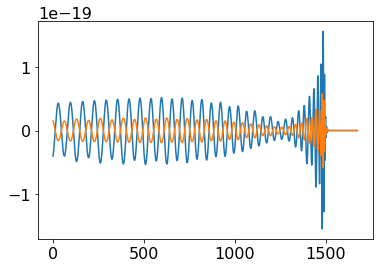

In [107]:
plt.figure()
plt.plot(range(len(h)), np.real(h))
plt.plot(range(len(h)), np.imag(h))

In [108]:
harms = _calculate_precessing_harmonics(
    mass_1=20, mass_2=10, chi_eff=0, chi_p=0.5, a_1=0.5, a_2=0, tilt_1=np.pi/2., tilt_2=0, phi_12=0, f_low=10, df=0.1,
    beta=np.pi/2, flen=None, harmonics=[0, 1, 2, 3, 4], approximant="SEOBNRv3"
)

0.0
0.0


ValueError: operands could not be broadcast together with shapes (44918,) (44899,) 

In [102]:
harms

{0: <pycbc.types.frequencyseries.FrequencySeries at 0x12b6e57d0>,
 4: <pycbc.types.frequencyseries.FrequencySeries at 0x12cbb49d0>,
 1: <pycbc.types.frequencyseries.FrequencySeries at 0x12b6e5f10>,
 3: <pycbc.types.frequencyseries.FrequencySeries at 0x1292d9d90>,
 2: <pycbc.types.frequencyseries.FrequencySeries at 0x12cbb4990>}

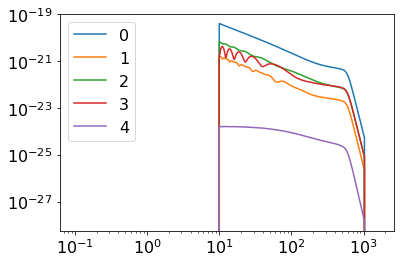

In [40]:
plt.figure()
for i in range(5):
    plt.plot(harms[i].sample_frequencies, np.abs(harms[i]), label=i)
plt.legend()
plt.yscale('log')
plt.xscale('log')

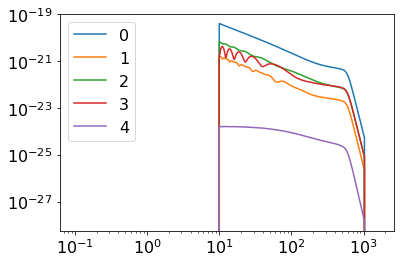

In [40]:
plt.figure()
for i in range(5):
    plt.plot(harms[i].sample_frequencies, np.abs(harms[i]), label=i)
plt.legend()
plt.yscale('log')
plt.xscale('log')